# imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

# load datasets
from sklearn import datasets

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function

# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score

# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# --------------------------------------------------
# models/estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# models : boost
import xgboost as xgb
import lightgbm
# --------------------------------------------------

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()

# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve

# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

# read datasets

In [2]:
diabetes = pd.read_csv('./kaggle/pima/diabetes.csv')

df = pd.DataFrame(diabetes)

X = df.drop('Outcome', axis=1)
y = df['Outcome']
X.info(); y.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


(768,)

# defs

In [3]:
def pr_curve(y_val, probas_pred):

    """threshold / precision, recall, f1 curve"""

    # plot_precision_recall_curve(model, X_val, y_val) # x=recall, y=precision
    precisions, recalls, thresholds = precision_recall_curve(y_val, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

    # settings
    plt.title('precision recall f1 curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('socre')

    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

    plt.legend()
    plt.show()

    return thresholds, precisions, recalls, f1_scores

In [4]:
def ra_curve(y_val, probas_pred):

    """ROC curve, auc_score"""
    
    FPRS, TPRS, thresholds = roc_curve(y_val, probas_pred[:, 1])

    # settings
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')

    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')

    plt.legend()
    plt.show()

    return FPRS, TPRS

In [5]:
def my_eval(th, y_val, y_pred, probas_pred, model, X_val):

    """th in th_list scorings"""
    
    print('-' * 28, 'threshold adjusting ', '-' * 28)

    f1        = f1_score        (y_val, y_pred)
    accuracy  = accuracy_score  (y_val, y_pred)
    AUC       = roc_auc_score   (y_val, probas_pred[:, 1])
    precision = precision_score (y_val, y_pred)
    recall    = recall_score    (y_val, y_pred)
    conf_matx = confusion_matrix(y_val, y_pred)

    print(f'threshold = {th:.4f}   '
          f'f1       = {f1:.4f}   '
          f'accuracy = {accuracy:.4f}   '
          f'AUC      = {AUC:.4f}\n'
          f'precision = {precision:.4f}   '
          f'recall   = {recall:.4f}   \n',
          conf_matx)

#     disp = plot_confusion_matrix(model, y_val, y_pred, cmap=plt.cm.Blues, normalize=None)
#     disp.ax_.set_title(th)
#     plt.show()

In [6]:
def max_eval(y_val, y_pred, probas_pred, 
             thresholds, f1_scores, precisions, recalls, FPRS, TPRS):
      
      """when f1 max, threshold & scorings"""
      
      print('-' * 34, 'max_eval', '-' * 34)

      f1max_idx = np.where(f1_scores == f1_scores.max())
      m_threshold = float(thresholds[f1max_idx])
      m_proba     = Binarizer(threshold=m_threshold).fit_transform(probas_pred[:, 1].reshape(-1, 1))

      max_f1      = f1_scores.max()
      m_accuracy  = accuracy_score (y_val, m_proba)
      m_AUC       = roc_auc_score(y_val, probas_pred[:, 1])
      m_precision = float(precisions[f1max_idx])
      m_recall    = float(recalls[f1max_idx])
      m_FPR       = float(FPRS[np.where(thresholds == m_threshold)])
      m_TPR       = float(TPRS[np.where(thresholds == m_threshold)])

      print(f'threshold = {m_threshold:.4f}   '
            f'max f1   = {max_f1:.4f}   '
            f'accuracy = {m_accuracy:.4f}   '
            f'AUC      = {m_AUC:.4f}\n'
            f'precision = {m_precision:.4f}   '
            f'recall   = {m_recall:.4f}   '
            f'FPR      = {m_FPR:.4f}   '
            f'TPR      = {m_TPR:.4f}')    

In [7]:
def split_fit_score(X, y, model=RandomForestClassifier(n_estimators=100, random_state=0),
                    test_size=0.2, th_list=[0.5], random_state=0):

    """train_test_split & fit_predict"""
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    probas_pred = model.predict_proba(X_val)
    
    # precision_recall_curve & ROC_curve & max_eval
    thresholds, precisions, recalls, f1_scores = pr_curve(y_val, probas_pred)
    FPRS, TPRS = ra_curve(y_val, probas_pred)
    # max_eval(y_val, y_pred, probas_pred, thresholds, f1_scores, precisions, recalls, FPRS, TPRS)

    # binarize loop
    for th in th_list:
        bin_probas = Binarizer(threshold=th).fit_transform(probas_pred[:, 1].reshape(-1, 1))
        my_eval(th, y_val, bin_probas, probas_pred, model, X_val)

# score v0

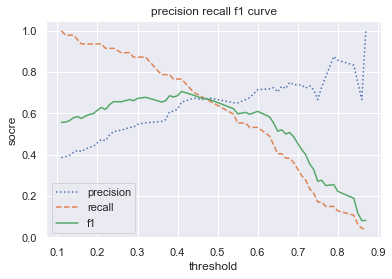

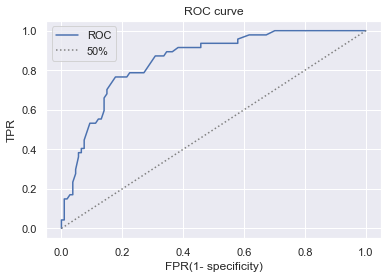

---------------------------- threshold adjusting  ----------------------------
threshold = 0.5000   f1       = 0.6374   accuracy = 0.7857   AUC      = 0.8493
precision = 0.6591   recall   = 0.6170   
 [[92 15]
 [18 29]]


In [8]:
split_fit_score(X, y, random_state=0)

# feature engineering

In [9]:
# zero_cols
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']
for COL in zero_cols:
    print(COL, df[df[COL]==0][COL].count()/df.shape[0]*100, df[df[COL]!=0][COL].count()/df.shape[0]*100) 

Glucose 0.6510416666666667 99.34895833333334
BloodPressure 4.557291666666666 95.44270833333334
SkinThickness 29.557291666666668 70.44270833333334
Insulin 48.69791666666667 51.302083333333336
BMI 1.4322916666666665 98.56770833333334


In [10]:
# age_band
df['Age_band'] = pd.cut(df['Age'], bins=[0,20,24,29,41,82,150],labels=[0,1,2,3,4,5] )
print((df[['Age','Age_band']].head()))
print(df['Age_band'].unique())

df[df['BloodPressure']>0].groupby(['Outcome','Age_band'])['BloodPressure'].mean()


   Age Age_band
0   50        4
1   31        3
2   32        3
3   21        1
4   33        3
[4, 3, 1, 2]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64

In [11]:
for COL in zero_cols:
    print(COL,  df[df[COL]>0].groupby(['Outcome','Age_band'])[COL].mean())
    print("---"*10)

Glucose Outcome  Age_band
0        0                  NaN
         1           107.594595
         2           107.451613
         3           113.133333
         4           119.060241
         5                  NaN
1        0                  NaN
         1           141.064516
         2           140.396226
         3           143.430108
         4           142.741573
         5                  NaN
Name: Glucose, dtype: float64
------------------------------
BloodPressure Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64
------------------------------
SkinThickness Outcome  Age_band
0        0                

In [12]:
df["Insulin"]       = df["Insulin"].fillna(df.groupby(by=["Outcome","Age_band"])["Insulin"].transform('mean'))
df["BloodPressure"] = df["BloodPressure"].fillna(df.groupby(by=["Outcome","Age_band"])["BloodPressure"].transform('mean'))
df["Glucose"]       = df["Glucose"].fillna(df.groupby(by=["Outcome","Age_band"])["Glucose"].transform('mean'))

df["BMI"]           = df["BMI"].fillna(df.groupby(by="Outcome")["BMI"].transform('mean'))
df["SkinThickness"] = df["SkinThickness"].fillna(df.groupby(by="Outcome")["SkinThickness"].transform('mean'))

df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Age_band                    0
dtype: int64

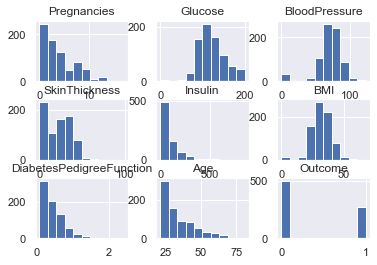

In [13]:
df.hist(); plt.show()

# score v1

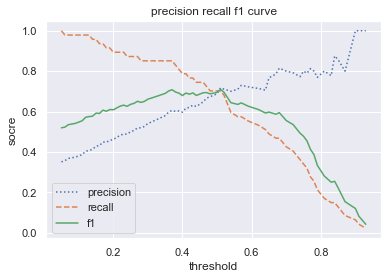

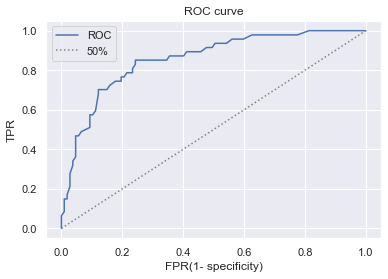

---------------------------- threshold adjusting  ----------------------------
threshold = 0.4000   f1       = 0.6916   accuracy = 0.7857   AUC      = 0.8552
precision = 0.6167   recall   = 0.7872   
 [[84 23]
 [10 37]]
---------------------------- threshold adjusting  ----------------------------
threshold = 0.4250   f1       = 0.6923   accuracy = 0.7922   AUC      = 0.8552
precision = 0.6316   recall   = 0.7660   
 [[86 21]
 [11 36]]
---------------------------- threshold adjusting  ----------------------------
threshold = 0.4500   f1       = 0.6931   accuracy = 0.7987   AUC      = 0.8552
precision = 0.6481   recall   = 0.7447   
 [[88 19]
 [12 35]]


In [14]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
split_fit_score(X, y, th_list=[0.4, 0.425, 0.45], random_state=0)

# scaling

# score v2

In [15]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
model = RandomForestClassifier(n_estimators=500)
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

for scaler in scalers:
    scaler.fit(X_train)   # fit은 train에만, 가진 데이터는 보통 train뿐이기 때문
    scaler_X_train = scaler.transform(X_train) # test를 묶어 fit하면 묶어서 인지하여 오버피팅
    scaler_X_test  = scaler.transform(X_test)
    print(scaler.__class__.__name__)   # test는 transform만 적용
    scaler_X = np.append(scaler_X_train, scaler_X_test, axis=0)    
    split_fit_score(scaler_X, y, model, )

NameError: name 'X_train' is not defined

# boost model

In [16]:
xgmodel = xgb.XGBClassifier(n_estimators=300, objective="binary:logistic")   #logloss
split_fit_score(scaler_X, y, xgmodel)   

NameError: name 'scaler_X' is not defined

# folds

In [71]:
accuarcy_total_score = []
f1_total_score = []
skfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for train_index, test_index in skfold.split(scaler_X, y):
    X_train, X_test = scaler_X[train_index], scaler_X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1       = f1_score(y_test, y_pred)
    
    accuarcy_total_score.append(accuracy)
    f1_total_score.append(f1)

print(np.array(accuarcy_total_score).mean())
print(np.array(f1_total_score).mean())
    

NameError: name 'scaler_X' is not defined

# code_test

In [229]:
df = pd.read_csv('./code_test/kote_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [230]:


# 'id': 등록자 ID
# 'city': 지역코드
# 'city_development_index': 지역개발지수
# 'gender': 성별
# 'relevent_experience': 관련경험
# 'enrolled_university': 대학과정
# 'education_level': 교육수준
# 'major_discipline': 전공
# 'experience':경력(년)
# 'company_size': 소속회사 직원수
# 'company_type': 소속회사 유형
# 'last_new_job': 현재 직업 경력(년)
# 'training_hours': 교육 이수 시간
# 'target': 목표변수, 다른 일을 찾는 경우1, 아니면 0

# goal ; AUC 구하기

# 1. target balance check
# 2. missing vl check

# target balance check
# encoding, missing vl, age_band, unique drop

# EDA

In [231]:
# drop unique
# df = df.drop('enrollee_id', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [232]:
# target balance check
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [233]:
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False)

company_type           6140
company_size           5938
gender                 4508
major_discipline       2813
education_level         460
last_new_job            423
enrolled_university     386
experience               65
dtype: int64

In [234]:
# missing vl ; gender, enrolled_university, educational_level, major_discipline, experience, company_size, company_type, last_new_job
df.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

In [235]:
# missing vl cols
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False).index

Index(['company_type', 'company_size', 'gender', 'major_discipline',
       'education_level', 'last_new_job', 'enrolled_university', 'experience'],
      dtype='object')

In [236]:
# object cols select
print(df.select_dtypes('object').columns)
df.dtypes[df.dtypes == 'object']

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


city                   object
gender                 object
relevent_experience    object
enrolled_university    object
education_level        object
major_discipline       object
experience             object
company_size           object
company_type           object
last_new_job           object
dtype: object

In [237]:
# 결측 비율 계산 ; 50% 이상이면 drop
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False)

nan_cols = df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False).index

# for col in missing_cols:
#     print(df[col].isna().sum() / df.shape[0], col)

nan_df = pd.DataFrame({'CNT':df.isna().sum(),
                       'RATE':df.isna().sum() / df.shape[0] * 100})
nan_df.sort_values('RATE', ascending=False)

,CNT,RATE
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284
enrollee_id,0,0.000000
city,0,0.000000


In [238]:
for col in nan_cols:
    print(col, 'unique =', df[col].unique()) # srs.unique()

company_type unique = [nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO']
company_size unique = [nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999']
gender unique = ['Male' nan 'Female' 'Other']
major_discipline unique = ['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other']
education_level unique = ['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']
last_new_job unique = ['1' '>4' 'never' '4' '3' '2' nan]
enrolled_university unique = ['no_enrollment' 'Full time course' nan 'Part time course']
experience unique = ['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]


In [239]:
for col in nan_cols:
    print(df[col].value_counts())
    print('-' * 30)

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64
------------------------------
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
------------------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64
------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
------------------------------
1        8040
>4       3290
2        2900
never  

In [240]:
# company_size binning
# <10          1308
# 10/49        1471
# 50-99        3083
# 100-500      2571
# 500-999       877
# 1000-4999    1328
# 5000-9999     563
# 10000+       2019
dict = {'<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8}
mapping = {'<10':0, '10/49':1, '50-99':2, '100-500':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}

df['company_size_band'] = df['company_size'].map(dict)
df[['company_size', 'company_size_band']].head(10)

,company_size,company_size_band
0,NaN,NaN
1,50-99,3.0
2,NaN,NaN
3,NaN,NaN
4,50-99,3.0
5,NaN,NaN
6,50-99,3.0
7,<10,1.0
8,50-99,3.0
9,10000+,8.0


In [241]:
df['company_size_band'].describe()

count    13220.000000
mean         4.253328
std          2.190880
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          8.000000
Name: company_size_band, dtype: float64

<AxesSubplot:xlabel='company_size_band', ylabel='count'>

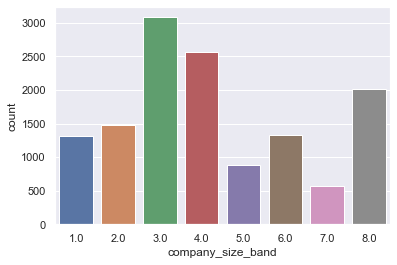

In [242]:
sns.countplot('company_size_band', data=df) # company_type과 연관 가능성

In [243]:
# company_type binning
dict = {'Pvt Ltd':1,'Funded Startup':2,'Public Sector':3,'Early Stage Startup':4,'NGO':5,'Other':6}

df['company_type_band'] = df['company_type'].map(dict)
df[['company_type', 'company_type_band']].head(10)

,company_type,company_type_band
0,NaN,NaN
1,Pvt Ltd,1.0
2,NaN,NaN
3,Pvt Ltd,1.0
4,Funded Startup,2.0
5,NaN,NaN
6,Funded Startup,2.0
7,Pvt Ltd,1.0
8,Pvt Ltd,1.0
9,Pvt Ltd,1.0


In [244]:
df[['company_type', 'company_type_band']].describe()

,company_type_band
count,13018.000000
mean,1.569135
std,1.155907
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6.000000


<AxesSubplot:xlabel='company_type_band', ylabel='count'>

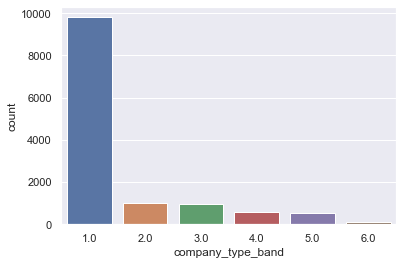

In [245]:
# df[['company_type', 'company_type_band']].hist()
sns.countplot('company_type_band', data=df) # company_type과 연관 가능성

In [246]:
# 회사유형별 평균 회사규모(구간)
df.groupby('company_type_band').mean()['company_size_band']

company_type_band
1.0    4.498459
2.0    2.840201
3.0    5.146489
4.0    1.805000
5.0    4.341414
6.0    4.371681
Name: company_size_band, dtype: float64

In [247]:
# 회사유형별 평균으로 company_size_band 결측치 처리
df.groupby('company_type_band').mean()['company_size_band'][1]

# company_type_band 결측치를 최빈값으로 처리
df['company_type_band'].mode()
df['company_type_band'] = df['company_type_band'].fillna(1)

In [248]:
df['company_type_band'].isna().sum()

0

In [249]:
nan = df.groupby('company_type_band')['company_size_band']
df['company_size_band'] = df['company_size_band'].fillna(nan.transform('mean'))

In [250]:
df[['company_size_band', 'company_type_band']].isna().sum()

company_size_band    0
company_type_band    0
dtype: int64

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
 14  company_size_band       19158 non-null

In [252]:
nan = df.isna().sum()[df.isna().sum() != 0]
for col in nan.index:
    print(col, df[col].unique().tolist())

gender ['Male', nan, 'Female', 'Other']
enrolled_university ['no_enrollment', 'Full time course', nan, 'Part time course']
education_level ['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']
major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']
experience ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]
company_size [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']
company_type [nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']
last_new_job ['1', '>4', 'never', '4', '3', '2', nan]


In [253]:
# LabelEncoder
# gender ; 1 2 3 
# major ; 1 2 3 ...
# edu ; 1 2 3 ...

# # 평준화 ; onehot, get_dummies()
# gender ['Male', nan, 'Female', 'Other']
# major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']

# # 레벨 유지 ; 수치형, 레벨 그대로 학습시키는 것이 좋음
# enrolled_university ['no_enrollment', 'Full time course', nan, 'Part time course']
# education_level ['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']
# experience ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]
# last_new_job ['1', '>4', 'never', '4', '3', '2', nan]

In [254]:
# LabelEncoder + 결측처리 + OneHotEncoder ; 결측처리 숫자=0, nan 뽑기가 어려움, 평준화
# 결측처리를 반드시 한 후 get_dummies해야 원하는 대로 결측처리 가능
# feature_unique로 컬럼을 생성하여, 1 0 정리
# 현업에서 굉장히 자주 사용
# label, onehot은 리스트도 가능
# get_d는 df만 가능

In [255]:
df2 = pd.get_dummies(df[['gender', 'education_level']])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   gender_Female                   19158 non-null  uint8
 1   gender_Male                     19158 non-null  uint8
 2   gender_Other                    19158 non-null  uint8
 3   education_level_Graduate        19158 non-null  uint8
 4   education_level_High School     19158 non-null  uint8
 5   education_level_Masters         19158 non-null  uint8
 6   education_level_Phd             19158 non-null  uint8
 7   education_level_Primary School  19158 non-null  uint8
dtypes: uint8(8)
memory usage: 149.8 KB


In [256]:
df2.head(10)

,gender_Female,gender_Male,gender_Other,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School
0,0,1,0,1,0,0,0,0
1,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0
5,0,0,0,1,0,0,0,0
6,0,1,0,0,1,0,0,0
7,0,1,0,1,0,0,0,0
8,0,1,0,1,0,0,0,0
9,0,0,0,1,0,0,0,0


In [257]:
# LabelEncoder 연습 ; 결측도 데이터처럼 처리
le = LabelEncoder() # input array, list
data = ['f', 'm', 'o', np.nan]
res = le.fit_transform(data); res

array([0, 1, 3, 2], dtype=int64)

In [258]:
le.inverse_transform(res)

array(['f', 'm', 'o', 'nan'], dtype='<U32')

<AxesSubplot:>

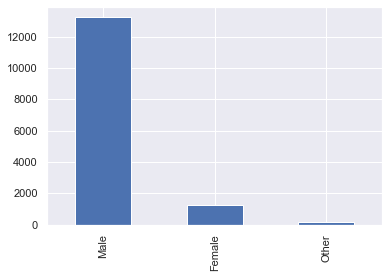

In [259]:
# 성별과 연관지을 수 있는 피쳐가 없음
df['gender'].value_counts().plot(kind='bar')

In [260]:
# 성별 결측치 남성으로 처리
df['gender'] = df['gender'].fillna('Male')

In [261]:

# 피쳐들의 연관성을 보는 것이 상관분석, -1 ~ 1, 1일수록 강한 양의 상관관계
# -0.1 ~ 0.1 상관관계 거의 없음
# 0.1 ~ 0.3 약한 상관관계
# 0.3 ~ 0.7 강한 상관관계
# 0.7 ~ 1.0 같은 피쳐라 여김, 매우 강한 상관관계, 다중공선(0.8 이상)
# 강한 상관관계의 피쳐들을 복수로 넣어서 학습시키면 좋은 분석이 아님, 다중공선성
# 강한 상관관계를 가진 피쳐를 합치든가 or 대표성을 가진 피쳐만 남겨둘 것
# drop; 대표성을 가진 피쳐만 남김. 상관관계가 적은 피쳐부터 drop
# 그러나 점수가 떨어지는 경우도 있음, 공모전에서는 넣기도 함
# PCA(차원축소); 피쳐를 합치는 것, 단점은 원상복구시킬 수 없음. 원래 데이터를 유추할 수 없음

# 상관분석 ; 두 연속형(실수) 변수(x, y) 간 선형적 관계 분석
# 선형관계가 있다면, 모수? 관계
# 상관관계는 연관된 정도일 뿐, 인과관계를 설명하지는 않음

# 양적 데이터; 수치 - 연속형(키, 몸무게), 이산형(1, 2, 3)
# 질적 데이터; 범주 - 명목형(순서가 중요하지 않은), (A/B/C class 등)

# 피어슨 상관계수 ; 연속형 수치
# 스피어만 상관계수 ; 범주형
# 일반적으로 피어슨을 많이 사용. 결과적으로 수치화할 수 있기 때문

# 분산 ; 한개의 변수의 값이 퍼져 있는 정도
# 공분산 ; 두 변수의 관계를 나타내는 양, 두 변수가 퍼져 있는 정도
# 표준화하여 비교하기 위해, 공분산보다 상관계수를 사용

# 다중공선성 ; 변수가 다른 변수와 상관정도가 높다, 데이터 분석 시 부정적인 영향을 미치는 현상


In [262]:
# str가 있어도 되지만, 빠져나가고 수치들만 분석해줌, 에러는 나지 않으나 나오지 않음
# 결측치를 처리 한 후, 해야 함
# 결측은 나중에 채우더라도, 수치화는 반드시 해야 함

# 그냥 상관분석 시도
df.corr()

,enrollee_id,city_development_index,training_hours,target,company_size_band,company_type_band
enrollee_id,1.000000,-0.040455,0.000998,0.049475,0.016251,-0.006124
city_development_index,-0.040455,1.000000,0.001920,-0.341665,0.065817,0.028376
training_hours,0.000998,0.001920,1.000000,-0.021577,-0.012917,0.008910
target,0.049475,-0.341665,-0.021577,1.000000,0.006297,-0.040059
company_size_band,0.016251,0.065817,-0.012917,0.006297,1.000000,-0.126643
company_type_band,-0.006124,0.028376,0.008910,-0.040059,-0.126643,1.000000


<AxesSubplot:>

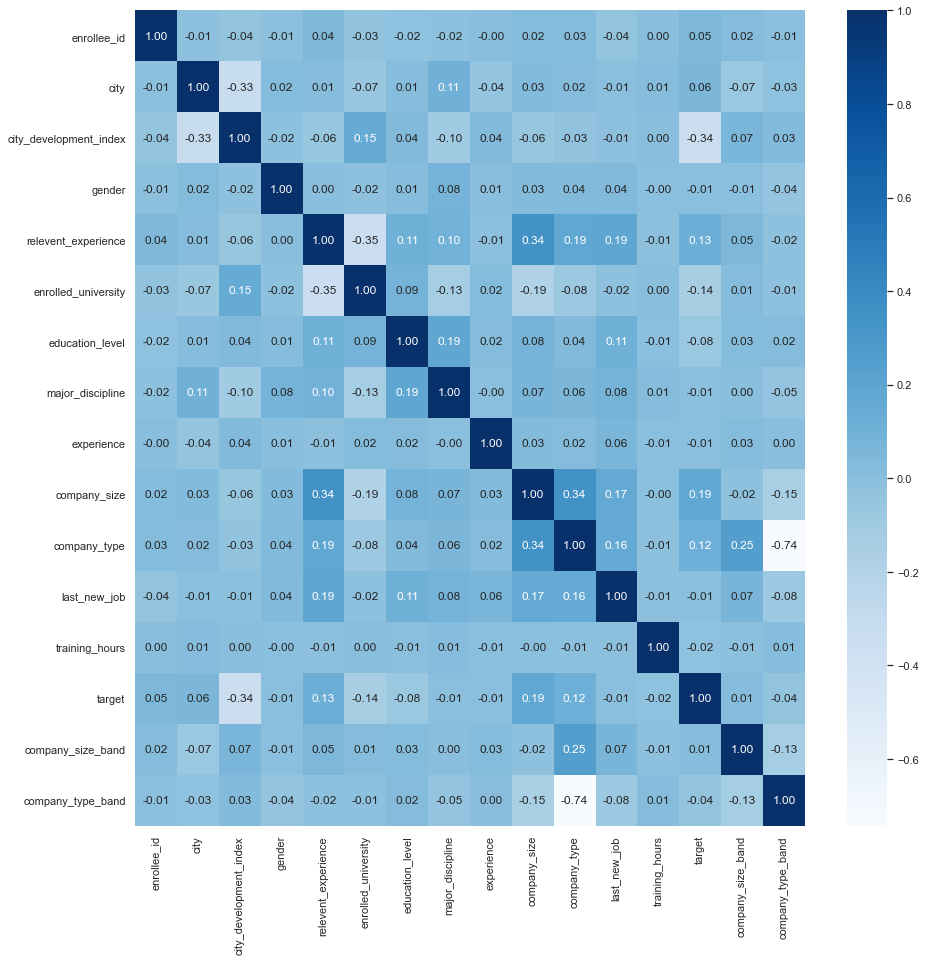

In [263]:
obj_cols = df.dtypes[df.dtypes == 'object'].index
df2 = df.copy()

for col in obj_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col])

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df2.corr(), annot=True, fmt='.2f', cmap='Blues')
# sns.heatmap(df2.corr().nlargest(5, 'target'), annot=True, fmt='.2f', cmap='vlag')

# sns.heatmap(data, 
#             annot=None, # 수치 표시 
#             fmt='.2g')  # 소수점 자릿수
# fmt = 'Blues', 'Blues_r',  'Greens', 'OrRd',  'PuBu', 'Purples', 'rocket_r'


<AxesSubplot:>

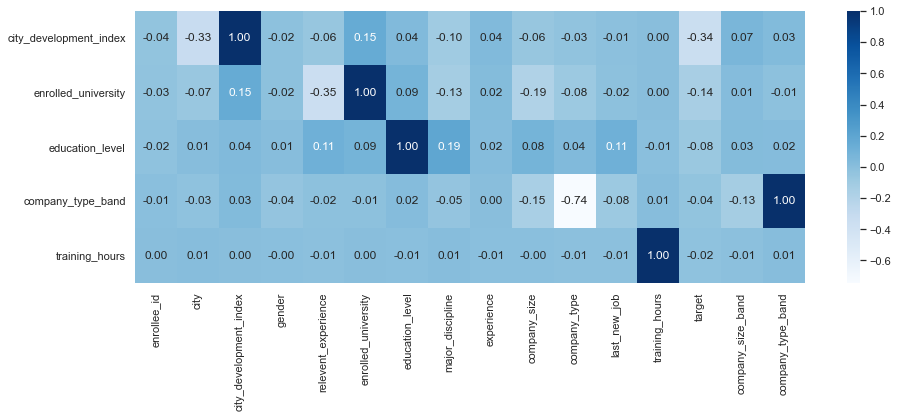

In [264]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df2.corr().nsmallest(5, 'target'), annot=True, fmt='.2f', cmap='Blues')

In [265]:
# enrolled_uni, relevent_exp 상관관계 확인
# sns.pairplot(df2[['enrolled_university', 'relevent_experience']])

In [266]:
for col in nan_cols:
    print(col, df[col].unique().tolist())
    print(df[col].value_counts())

company_type [nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64
company_size [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
gender ['Male', 'Female', 'Other']
Male      17729
Female     1238
Other       191
Name: gender, dtype: int64
major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64
education_level ['Graduate

In [267]:
# nan ; 최빈도값으로 채우기
# enrolled_university ; no_enrollment
# education_level ; Graduate
# major_discipline ; STEM
# experience ; 평균
# company_type ; Pvt Ltd
# company_size ; company_type 그룹별 평균
# last_new_job ; 1

In [272]:
# 컬럼별로 들어갈 값이 정해져 있음.
# df[col].fillna(df[col].mode()[0]) 최빈값은 0을 찍어줘야 함

In [275]:
nan_cols = ['enrolled_university', 'education_level', 'major_discipline',
            'experience', 'company_size', 'company_type', 'last_new_job']

for col in nan_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [277]:
# print(df.columns)
nan = df.isna().sum()[df.isna().sum() != 0]
print('nan cols cnt =', len(nan.index))
print(nan.index)

for col in nan.index:
    print('-' * 30)
    print('cnt =', df[col].count())
    print('nan =', df[col].isna().sum())
    print(df[col].value_counts())

nan cols cnt = 0
Index([], dtype='object')


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
 14  company_size_band       19158 non-null

In [282]:
drop_cols = ['enrollee_id', 'company_type', 'company_size']
df = df.drop(drop_cols, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  object 
 8   last_new_job            19158 non-null  object 
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
 11  company_size_band       19158 non-null  float64
 12  company_type_band       19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [284]:
df = pd.get_dummies(df, columns=['gender', 'major_discipline'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   city                              19158 non-null  object 
 1   city_development_index            19158 non-null  float64
 2   relevent_experience               19158 non-null  object 
 3   enrolled_university               19158 non-null  object 
 4   education_level                   19158 non-null  object 
 5   experience                        19158 non-null  object 
 6   last_new_job                      19158 non-null  object 
 7   training_hours                    19158 non-null  int64  
 8   target                            19158 non-null  float64
 9   company_size_band                 19158 non-null  float64
 10  company_type_band                 19158 non-null  float64
 11  gender_Male                       19158 non-null  uint8  
 12  gend

In [285]:
# int casting ; target, company_type_band
# df[col].astype('int')

In [286]:
df[df.select_dtypes('object').columns].head(20)

,city,relevent_experience,enrolled_university,education_level,experience,last_new_job
0,city_103,Has relevent experience,no_enrollment,Graduate,>20,1
1,city_40,No relevent experience,no_enrollment,Graduate,15,>4
2,city_21,No relevent experience,Full time course,Graduate,5,never
3,city_115,No relevent experience,no_enrollment,Graduate,<1,never
4,city_162,Has relevent experience,no_enrollment,Masters,>20,4
5,city_176,Has relevent experience,Part time course,Graduate,11,1
6,city_160,Has relevent experience,no_enrollment,High School,5,1
7,city_46,Has relevent experience,no_enrollment,Graduate,13,>4
8,city_103,Has relevent experience,no_enrollment,Graduate,7,1
9,city_103,Has relevent experience,no_enrollment,Graduate,17,>4


In [ ]:
# X =
# y =
# model = RandomForestClassifier(n_estimators=300, random_state=0)
# split_fit_score()
# logloss 원본값과의 차이를 점수로